In [1]:
import dash
import dash_core_components as dcc
import dash_html_components as html

from dash.dependencies import Input, Output, State

import dash_cytoscape as cyto
import networkx as nx

import json
import csv

import datetime

# Get lists nodes and edges, make NetworkX

In [2]:
G = nx.Graph()


with open('./data_us/TrumpProsecutors_initiallist.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        
        dateYear = row['Date of Appointment']
        
        distr = row['District'].replace("U.S. Attorney for the ","")
        
        G.add_node(row['Wikidata ID'], name=row['Attorney'],
                                     distr = distr,
                                     date = dateYear)
        #print(row['Wikidata ID'],dateYear)
        #print(row['District'],row['Attorney'],row['Wikidata ID'],row['Date of Appointment'])

In [3]:
#G.nodes.data()
for n in G.nodes:    
    with open('./data_us/Foto_us.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if n == row['Wikidata ID']:
                #print(n,row['Wikidata ID'],row['Img_url'])
                G.nodes[n]['img_url'] = row['Img_url']

#ndes_from_nx

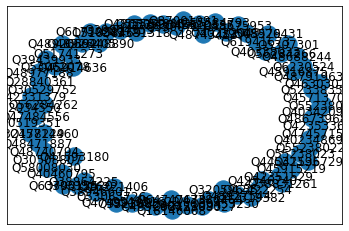

In [4]:
nx.draw_networkx(G)

In [5]:
listYear = ['2015','2016', '2017', '2018', '2019', '2020']

for y in listYear:
    groupYear = []
    for n in G.nodes.data():
        if y in n[1]['date']:
            groupYear.append(n[0])
            #print(n[1]['date'])
    
    #print(groupYear)
    
    if len(groupYear) <= 1:
        continue
    
    for n in groupYear:
        if groupYear[0] == n:
            continue
        else:
            G.add_edge(groupYear[0],n)

    

# Prepare data of nodes and edges for Cytocscape 

In [6]:
edges_from_nx = []

for n in G.edges.data():
    edges_from_nx.append({'data': {'source': n[0],
                                  'target':n[1]
                                  }
                         }
                        )
    

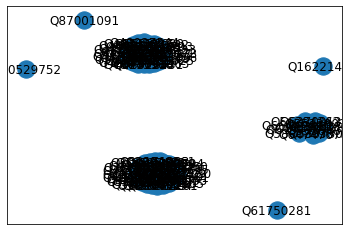

In [7]:
nx.draw_networkx(G)

In [8]:
nodes_from_nx = []

for n in G.nodes.data():
    classesStr = 'img '+n[0]
    
    nodes_from_nx.append({'data': {'id': n[0],
                                  'name':n[1]['name'],
                                  'distr':n[1]['distr'],
                                  'date':n[1]['date'],
                                  'url':n[1]['img_url']},
                         'classes':classesStr
                         })


## Network

In [9]:
net = nodes_from_nx+edges_from_nx

## Default_stylesheet

In [10]:
default_stylesheet = [
        # Group selectors
        {
            'selector': 'node',
            'style': {
                'content': 'data(id)',
                'width': "30",
                'height': "30"
            }
        },

        # Class selectors
        {'selector': '.img',
         'style':{
           'background-image': 'data(url)', 
            'background-fit': 'cover cover',
             'shape':'rectangle'
         }
        }
    ]

# Build dashboard

In [11]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)


In [12]:
app.layout = html.Div(style={'backgroundColor':'MintCream',"border":"2px red solid"},children=[
    
    #container
    html.Div(className='row',style = {'height':'95vh'},children=[
        
        #network ----------------------
        html.Div(className="six columns",style={"border":"2px grey solid",'height':'100%'},children =[
            html.P('Netwok'),
            
            cyto.Cytoscape(
            id='cytoscape',
            boxSelectionEnabled = True,
            layout={'name': 'grid'},
            style={'width': '100%', 'height': '80%',"border":"2px green solid"},
            stylesheet = default_stylesheet,
            elements=net
        ),
            html.Div(children=[
            html.P('Timeline does not work'),    
            dcc.Slider(      
            min=2010,
            max=2020,
            marks={i: '{}'.format(i) for i in range(2010,2021)},
            value=2017,
        )])
              
        ]),
        #-------------------------------
        
        #right 1/2 side basic ===================================
        html.Div(className="two columns",
                 style={"border":"2px black solid",
                        'backgroundColor':'LightGreen',
                        'padding':'10px'},children=[
            html.H3("Basic"),
            html.H5("Layout"),
            
            dcc.Dropdown(
            id='dropdown-layout',
            value='grid',
            clearable=False,
            options=[
                {'label': name.capitalize(), 'value': name}
                for name in ['grid', 'random', 'circle', 'cose', 'concentric','breadthfirst']
            ]
        ),
            html.Br(),
            html.H5("Label"),
            dcc.Dropdown(
            id='Dropdown-label-node',    
            options=[  
                {'label': 'Id', 'value': 'data(id)'},
                {'label': 'Name','value': 'data(name)'},
                {'label': 'Distr','value': 'data(distr)'},
                {'label': 'Date','value': 'data(date)'}
                    
            ],
            value= 'data(id)'
            #multi=True
            
    ),
        dcc.Checklist(id = 'Check-Box-Img-Node',options=[
        {'label': 'Img', 'value': 'data(url)'}],
                     value = []
                     )  
        
            
        ]),
        
        #right 2/2 show data cliked node 
        html.Div(className="four columns",
                 style={"border":"2px black solid",
                        'backgroundColor':'LightGreen',
                        'padding':'10px'},children=[
                     html.H3('Data'),
                     html.Div(children=["tapNodeData",html.Pre(id='test1',children=[])]),
                     html.Div(children=["selectedNodeData",html.Pre(id='test2',children=[])]),
                     
                     html.Div(children=['stylesheetCurrent',html.Pre(id='style-check',children=[])])
                 ]),
        #====================================================
                          
                    ])
        ])
    



## Side for functionality and adjust tools

In [13]:
@app.callback(Output('cytoscape', 'layout'),
              [Input('dropdown-layout', 'value'),
               Input('cytoscape', 'selectedNodeData')])
def update_layout(value,selectedNodeData):
    
    if selectedNodeData is not None and value == "breadthfirst" :
        node_list = []
        for n in selectedNodeData:
            id_node = '#'+n["id"]
            node_list.append(id_node)   
            nodes = ', '.join(node_list)
    
        return {
            'name': value,
            'animate': True,
            'roots':nodes
        }
    
    else:
        return {
            'name': value,
            'animate': True,
        }

In [14]:
@app.callback(Output('test1', 'children'),
              [Input('cytoscape', 'tapNodeData')])
def displayTapNodeData(tapNodeData):

    return json.dumps(tapNodeData, indent=2)
    

In [15]:
@app.callback(Output('test2', 'children'),
              [Input('cytoscape', 'selectedNodeData')])
def displaySelectedNodeData(selectedNodeData):
    return json.dumps(selectedNodeData, indent=2)


In [16]:
@app.callback([Output('cytoscape', 'stylesheet'),Output('style-check', 'children')],
              [Input('Dropdown-label-node', 'value'),
              Input('Check-Box-Img-Node','value'),
              Input('cytoscape', 'tapNodeData'),Input('cytoscape', 'selectedNodeData')])

def Generate_stylesheet(Dropdown_label,Check_Box_Img,tapNodeData,selectedNodeData):

    if Dropdown_label is None:
        Dropdown_label = ''
        
    if Check_Box_Img is None:
        Check_Box_Img = ''
    
    
############################################################


    update_stylesheet = [
        # Group selectors
        {
            'selector': 'node',
            'style': {
                'content': Dropdown_label,
                'width': "30",
                'height': "30"
            }
        },

        # Class selectors
        {'selector': '.img',
         'style':{
           'background-image': Check_Box_Img, 
            'background-fit': 'cover cover',
             'shape':'rectangle'
         }
        }
    ]
    
    if tapNodeData is not None:
        nodeClick = '.'+tapNodeData['id']
        
        listFolofers = []
        for e in edges_from_nx:
            if e['data']['source'] == tapNodeData['id']:
                t = '.'+e['data']['target']
                listFolofers.append(t)
        listFolofers.append(nodeClick)
        
        s = ', '.join(listFolofers)
        
        folovers_style = [{
                            'selector': s,
                            'style': {
                                'background-color': 'red',
                                'border-width': '5',
                                'border-color':'red'
                            }}]
    if selectedNodeData == []:
        folovers_style = [{
                        'selector': '',
                        'style': {
                            'background-color': 'red',
                            'border-width': '5',
                            'border-color':'red'
                        }}]
        
    update_stylesheet = update_stylesheet + folovers_style

    return update_stylesheet,json.dumps(update_stylesheet, indent=2)

## RUN

In [17]:
if __name__ == '__main__':
    app.run_server(debug=False) # Jupiter doesn't work with debug=True

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [15/May/2020 20:08:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:45] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:45] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:45] "GET /_favicon.ico?v=1.12.0 HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:46] "POST /_dash-update-component HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/pdk/.local/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/pdk/.local/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/pdk/.local/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/pdk/.local/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/pdk/.local/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/pdk/.local/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "/home/pdk/.local/lib/python3.6/site-packages/dash/dash.py", line 1032, in dispatch
    

127.0.0.1 - - [15/May/2020 20:08:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:46] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [15/May/2020 20:08:46] "GET /NOT HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:46] "GET /FOUND HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2020 20:08:51] "POST